# The Hitchhiker's Guide to Prior-Shift Adaptation

This sample code for prior shift adaptation is a supplementary material for the paper: 

Tomas Sipka, Milan Sulc and Jiri Matas. [The Hitchhiker's Guide to Prior-Shift Adaptation](http://arxiv.org/abs/2106.11695). arXiv: 2106.11695, 2021.

In [1]:
import torch
import pandas as pd
from algorithms import *
import matplotlib.pyplot as plt
from IPython.display import display

pd.set_option("display.precision", 2)
pd.set_option("display.float_format", '{:0.2f}'.format)

# Load predictions (logits)

Predictions of a resnet-32 classifier trained on CIFAR100-LT with imbalance ratio 112.5, as described in the paper. The label distribution is plotted below.

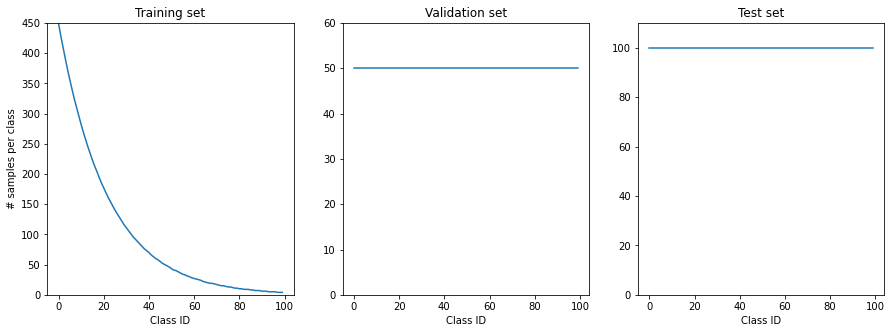

In [2]:
predictions_dict = torch.load('CIFAR100_LT_outputs/outputs.pth.tar', map_location=torch.device('cpu'))
outputs_train = predictions_dict['outputs_train'].detach().to('cpu')
targets_train = predictions_dict['targets_train'].detach().to('cpu')
outputs_val = predictions_dict['outputs_val'].detach().to('cpu')
targets_val = predictions_dict['targets_val'].detach().to('cpu')
outputs_test = predictions_dict['outputs_test'].detach().to('cpu')
targets_test = predictions_dict['targets_test'].detach().to('cpu')

# count samples per class
num_classes = outputs_val.shape[1]
classes_train = count_classes(targets_train, num_classes)
classes_val = count_classes(targets_val, num_classes)
classes_test = count_classes(targets_test, num_classes)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))
ax1.plot(classes_train)
ax1.set(ylim=(0, classes_train.max()), xlabel='Class ID', ylabel='# samples per class', title='Training set')

ax2.plot(classes_val)
ax2.set(ylim=(0, classes_val.max()+10), xlabel='Class ID', title='Validation set')

ax3.plot(classes_test)
ax3.set(ylim=(0, classes_test.max()+10), xlabel='Class ID', title='Test set');

# Classifier calibration
The predictions are calibrated using Bias Corrected Temperature Scaling (BCTS) proposed in [1]

[1] Amr  Alexandari, Anshul Kundaje, and Avanti Shrikumar. Maximum likelihood with bias-corrected calibration is hard-to-beat at label shift adaptation. ArXiv, 1901.06852v5, 2019.
https://arxiv.org/pdf/1901.06852.pdf

In [7]:
classes_train = classes_train / classes_train.sum()
classes_val = classes_val / classes_val.sum()
weights = classes_train / classes_val
weights = weights / weights.sum() # class weights to compensate the diffirence in train and val. distributions

# apply calibration
T, b = learn_calibration(outputs_val, targets_val, lr=0.0001, iters=100, weights=ratio)
preds_train = torch.softmax(outputs_train/T + b, dim=1)
preds_val = torch.softmax(outputs_val/T + b, dim=1)
preds_test = torch.softmax(outputs_test/T + b, dim=1)

# compute classfier priors after calibration
classifier_priors = torch.mean(preds_train, dim=0)

# compute confusion matrices after calibration
conf_mat = hard_confusion_matrix(preds_val, targets_val)
conf_soft_mat = soft_confusion_matrix(preds_val, targets_val)
conf_joint_mat = joint_confusion_matrix(preds_val, targets_val, classifier_priors / classes_val)
conf_joint_soft_mat = compute_joint_soft_confusion_matrix(preds_val, targets_val, classifier_priors / classes_val)

Before calibration - NLL: 3.079 
After calibration - NLL: 2.006 


# Prior shift adaptation

In [4]:
# Prepare structure for results
alg_list = ['NA', 'Oracle', 'CM', 'SCM', 'BBSE', 'BBSE-S', 'EM', 'CM$^L$', 'SCM$^L$', 'MAP', 'CM$^M$', 'SCM$^M$']
results = dict()

priors_test_gt = count_classes(targets_test, num_classes)
priors_test_gt = priors_test_gt/priors_test_gt.sum()

# No adaptation
results['NA'] = accuracy(preds_test, targets_test)

# Oracle
preds = adjust_predictions(preds_test, classifier_priors, priors_test_gt)
results['Oracle'] = accuracy(preds, targets_test)

# EM
preds, est_prior = EM_priors_estimation(preds_test, classifier_priors, termination_difference=0.001)
results['EM'] = accuracy(preds, targets_test)

# MAP
preds, est_prior = MAP_estimate(preds_test, classifier_priors, num_iter=1000, lr=5e-8 , termination_difference=1e-5, alpha=3)
results['MAP'] = accuracy(preds, targets_test)

# CM
est_prior = CM_estimate(preds_test, conf_mat, soft=False)
preds = adjust_predictions(preds_test, classifier_priors, est_prior)
results['CM'] = accuracy(preds, targets_test)

# SCM
est_prior = CM_estimate(preds_test, conf_soft_mat, soft=True)
preds = adjust_predictions(preds_test, classifier_priors, est_prior)
results['SCM'] = accuracy(preds, targets_test)

# BBSE
est_weight = BBSE_estimate(preds_test, conf_joint_mat, soft=False)
preds = adjust_predictions(preds_test, torch.ones_like(est_weight), est_weight)
results['BBSE'] = accuracy(preds, targets_test)

# BBSE-S
est_weight = BBSE_estimate(preds_test, conf_joint_soft_mat, soft=True)
preds = adjust_predictions(preds_test, torch.ones_like(est_weight), est_weight)
results['BBSE-S'] = accuracy(preds, targets_test)

# CM-L
preds, est_prior = matrix_correction_MLE(preds_test, classifier_priors, conf_mat, soft=False, max_iter=1000, lr=1e-4)
results['CM$^L$'] = accuracy(preds, targets_test)

# SCM-L
preds, est_prior = matrix_correction_MLE(preds_test, classifier_priors, conf_soft_mat, soft=True, max_iter=1000, lr=1e-3)
results['SCM$^L$'] = accuracy(preds, targets_test)

# CM-M
preds, est_prior = matrix_correction_MAP(preds_test, classifier_priors, conf_mat, soft=False, max_iter=1000, lr=1e-3, alpha=3)
results['CM$^M$'] = accuracy(preds, targets_test)

# SCM-M
preds, est_prior = matrix_correction_MAP(preds_test, classifier_priors, conf_soft_mat, soft=True, max_iter=1000, lr=1e-3, alpha=3)
results['SCM$^M$'] = accuracy(preds, targets_test)

# display results
data_acc = [ results[item] for item in alg_list]
df_acc = pd.DataFrame(data=data_acc, columns=['Accuracy'])
df_acc.set_index([[item for item in alg_list]], inplace=True)
display(df_acc.transpose())


,NA,Oracle,CM,SCM,BBSE,BBSE-S,EM,CM$^L$,SCM$^L$,MAP,CM$^M$,SCM$^M$
Accuracy,33.79,36.94,25.99,25.74,30.44,28.87,32.19,34.98,35.90,32.65,36.29,36.69
